**CMP585 - Structural Bioinformatics**

Cristian Lopes

*Assignment 4*

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import os

# Load Data

In [2]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                atoms.append({'atom_name': line[12:16].strip(),
                              'element': line[77:78].strip(),
                             'residue_name': line[17:20].strip(),
                             'residue_seq_number': line[22:26].strip(),
                             'x': float(line[30:38].strip()), 
                             'y': float(line[38:46].strip()),
                             'z': float(line[46:54].strip())})
    return pd.DataFrame(atoms)

In [3]:
molecule = read_molecule('./data/1rop.pdb')

In [4]:
molecule.head(20)

,atom_name,element,residue_name,residue_seq_number,x,y,z
0,N,N,MET,1,31.007,2.290,18.034
1,CA,C,MET,1,32.390,2.582,17.546
2,C,C,MET,1,32.808,1.432,16.618
3,O,O,MET,1,32.375,0.280,16.846
4,CB,C,MET,1,33.271,2.428,18.810
5,CG,C,MET,1,34.257,3.540,18.961
6,SD,S,MET,1,35.104,3.150,20.545
7,CE,C,MET,1,33.734,3.285,21.683
8,N,N,THR,2,33.714,1.715,15.687
9,CA,C,THR,2,34.312,0.620,14.917


# Q1 - a) Peptide Bond

First of all, we define the symbol of each amino acid.

In [5]:
symbol_to_residue_name = {
    'T': 'THR', 'C': 'CYS', 'P': 'PRO', 'S': 'SER', 'I': 'ILE',
    'V': 'VAL', 'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'F': 'PHE',
    'L': 'LEU', 'G': 'GLY', 'E': 'GLU', 'D': 'ASP', 'Y': 'TYR',
    'M': 'MET', 'K': 'LYS', 'Q': 'GLN', 'H': 'HIS', 'W': 'TRP'
}

## Load Amino Acids

Then, we load the amino acids from the Protein Data Bank.

In [6]:
AMINOACID_PATH = './data/amino_acids/'
aminoacids = pd.DataFrame()

for f in glob.glob(AMINOACID_PATH + "*.pdb"):
    aminoacids = aminoacids.append(read_molecule(f))

Right now, we have a dictionnary of amino acids containing the position of each atom inside the amino acid.

## Translation and rotation

Next step is to replace each symbol of the primary structure by its corresponding residue. First, we define a translation and a rotation function to move and rotate the next amino acid given the position of the previous aminoacid.

In [7]:
def translate(aminoacid, translation):
    aminoacid[['x', 'y', 'z']] = aminoacid[['x', 'y', 'z']] + translation
    return aminoacid

In [8]:
def translation_to_origin(aminoacid, ref_atom='N'):
    ref_translation = aminoacid[aminoacid.atom_name == ref_atom][['x', 'y', 'z']].values.reshape(-1)
    return ref_translation, translate(aminoacid, -ref_translation)

def rotate(aminoacid, angle_x, angle_y, angle_z):  
    Rx = [[1, 0, 0], [0, np.cos(angle_x), -np.sin(angle_x)], [0, np.sin(angle_x), np.cos(angle_x)]]
    Ry = [[np.cos(angle_y), 0, np.sin(angle_y)], [0, 1, 0], [-np.sin(angle_y), 0, np.cos(angle_y)]]
    Rz = [[np.cos(angle_z), -np.sin(angle_z), 0], [np.sin(angle_z), np.cos(angle_z), 0], [0, 0, 1]]
    R = np.dot(np.dot(Rx, Ry), Rz)
    display(R)
    
    ref_translation, aminoacid = translation_to_origin(aminoacid)
    display(aminoacid)
    aminoacid[['x', 'y', 'z']] = R.dot(aminoacid[['x', 'y', 'z']].values.T).T
    aminoacid = translate(aminoacid, ref_translation)

    return aminoacid

## Peptide Bond  Formation

A peptide bond is a chemical bond formed between two molecules when the carboxyl group of one molecule reacts with the amino group of the other molecule, releasing a molecule of water (H2O). So, given the position of the Oxygen of the carboxyl group of the previous molecule and the position of the Nitrogen of the next molecule, we can translate the next molecule in order for its Nitrogen to be around the Oxygen position of the previous molecule.

In [9]:
sequence = 'MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHADELYRSCLARF' # GDDGENL'

In [10]:
def _calculate_translation(previous_aminoacid, next_aminoacid):
    o_pos = previous_aminoacid[previous_aminoacid.atom_name == 'OC'][['x', 'y', 'z']].values.reshape(-1)
    n_pos = next_aminoacid[next_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
    return o_pos - n_pos       

def _remove_H2O(aminoacid):
    return aminoacid[~aminoacid.atom_name.isin(['OC', 'HC', '1H'])]

def assemble_3D_structure(sequence, aminoacids_df):
    protein = pd.DataFrame(data=None, columns=['atom_name', 'element','residue_name', 'residue_seq_number', 'x', 'y', 'z'])    
    previous_aminoacid, rotation = None, (0.0, 0.0, 0.0)
    
    for i, r in enumerate(sequence):
        aminoacid = aminoacids_df[aminoacids_df.residue_name == symbol_to_residue_name[r]].copy()
              
        if previous_aminoacid is not None:
            translation = _calculate_translation(previous_aminoacid, aminoacid)
            aminoacid = translate(aminoacid, translation)
        
        aminoacid['residue_seq_number'] = str(i+1)
        
        previous_aminoacid = aminoacid
        
        aminoacid = _remove_H2O(aminoacid)
        protein = protein.append(aminoacid, sort=True, ignore_index=True)
     
    return protein

In [11]:
protein = assemble_3D_structure(sequence, aminoacids)

In [12]:
protein.head()

,atom_name,element,residue_name,residue_seq_number,x,y,z
0,N,N,MET,1,0.071,-0.215,0.000
1,CA,C,MET,1,1.519,-0.024,0.000
2,C,C,MET,1,1.871,1.444,0.000
3,O,O,MET,1,1.002,2.328,0.000
4,CB,C,MET,1,2.146,-0.745,-1.225


## Save to .pdb

In [13]:
def write_atom_to_file(atom_seq_number, atom_row, element, f):
    if len(atom_row.atom_name) < 4:
        atom_seq_number += 1
        template_row =\
        'ATOM    '+\
        ('%d'%atom_seq_number).rjust(3)+\
        '  '+\
        ('%s'%atom_row[0]).ljust(4)+\
        ''+\
        ('%s'%atom_row.residue_name).rjust(3)+\
        ' A'+\
        ('%s'%atom_row.residue_seq_number).rjust(4)+\
        '    '+\
        ('%.3f'%atom_row.x).rjust(8)+\
        ('%.3f'%atom_row.y).rjust(8)+\
        ('%.3f'%atom_row.z).rjust(8)+\
        '  1.00 10.00           '+\
        ('%s  \n'%(element))
        f.write(template_row)
    return atom_seq_number
    

def write_pdb(file_name, protein):
    atom_seq_number = 0

    with open(file_name, 'w') as f:
        for idx in range(len(protein.residue_seq_number.unique())):
            for _, atom_row in protein[protein.residue_seq_number == str(idx+1)].iterrows():
                element = 'C' if atom_row.element == '' else atom_row.element
                atom_seq_number = write_atom_to_file(atom_seq_number, atom_row, element, f)

In [14]:
write_pdb('1ROP-P.pdb', protein)

# Q1 - b) Protein 3D Structure Prediction

## Tinker Utilities

In [15]:
def phi_psi_to_xyz(file_name, sequence, phis_psis):
    residues_sequence_list = ['%s %f %f' % (symbol_to_residue_name[res], phi, psi) \
                              for res, phi, psi in zip(sequence, phis_psis[0::2], phis_psis[1::2])]
    residues_sequence_str = '\\n'.join(residues_sequence_list)
    
    os.system(r'printf "%s\n\n./tinker/charmm22\n%s\n\n\n" | .\tinker\protein.exe' % (file_name, residues_sequence_str))


def phi_psi_to_pdb(file_name, sequence, phis_psis):
    def fix_generated_pdb(file_name):
        protein = read_molecule(file_name)
        write_pdb(file_name, protein)
        
    os.system(r'rm %s.pdb' % (file_name))
              
    phi_psi_to_xyz(file_name, sequence, phis_psis)   
    os.system(r'printf "%s\n./tinker/charmm22\n" | .\tinker\xyzpdb.exe' % (file_name))
    
    fix_generated_pdb(file_name+'.pdb')
    delete_protein_files(file_name)
    
    return read_molecule(file_name+'.pdb')


def energy(file_name):
    output = os.popen(r'printf "%s\n./tinker/charmm22\nE" | .\tinker\analyze.exe' % (file_name)).read()
    return float(output[1575:1598].replace("D","e"))


def delete_protein_files(file_name):
    os.system(r'rm %s.xyz %s.seq %s.int' % tuple([file_name]*3))

## Genetic Algorithm

In [16]:
class GeneticAlgorithm:
    def __init__(self, sequence, n_population):
        self.DIM_POPULATION = 2 * len(sequence)
        self.N_POPULATION = n_population
        self.sequence = sequence
        
        self.average_fitness = []
        
        self.population = self.initialize_population()
        self.fitness = self.compute_population_fitness()
        self.previous_fitness = None

        self.absolute_iteration = 0


    # Initialization
    def initialize_population(self):
        initial_population = [180.0 * np.random.uniform(-1, 1, self.DIM_POPULATION)
                              for _ in range(self.N_POPULATION)]

        return np.clip(initial_population, -180.0, 180.0)

    def generate_new_population(self):
        new_population = []
        for _ in range(self.N_POPULATION // 2):
            childrens = self.intermediate_recombination()
            new_population.extend([self.gaussian_convolution(children) for children in childrens])

        return np.clip(new_population, -180.0, 180.0)

    # Fitness
    def individual_fitness(self, individual):
        phi_psi_to_xyz('individual', self.sequence, individual)
        fitness = energy('individual')
        delete_protein_files('individual')
        
        return fitness

    def compute_population_fitness(self):
        population_fitness = []
        for individual in self.population:
            population_fitness.append(self.individual_fitness(individual))

        return population_fitness

    # Selection
    def fitness_proportionate_selection(self):
        probabilities = (np.max(self.fitness) - self.fitness) / np.sum(np.max(self.fitness) - self.fitness)
        idx = np.random.choice(self.N_POPULATION, replace=True, p=probabilities)

        return self.population[idx]

    # Crossover
    def intermediate_recombination(self):
        p = 0.2
        alpha = np.random.uniform(-p, 1+p)
        beta = np.random.uniform(-p, 1+p)

        parent_1 = self.fitness_proportionate_selection()
        parent_2 = self.fitness_proportionate_selection()

        children_1 = alpha * parent_1 + (1 - alpha) * parent_2
        children_2 = beta * parent_1 + (1 - beta) * parent_2

        return [children_1, children_2]

    # Mutation
    def gaussian_convolution(self, children):
        add_noise_prob = np.random.rand(self.DIM_POPULATION)

        sigma = 10.0
        noise = sigma * np.random.randn(self.DIM_POPULATION)

        return children + noise * (add_noise_prob > 0.5)

    def done(self, epsilon, iteration, max_iteration):
        converged = (np.abs(np.mean(self.fitness) - np.mean(self.previous_fitness)) < epsilon) \
                     if self.previous_fitness is not None else False
        taking_too_long = iteration >= max_iteration

        return converged or taking_too_long

    def show_results(self):
        print('\nOptimal Solution:')
        optimal = self.population[np.argmin(self.fitness)]
        for i, (phi, psi) in enumerate(zip(optimal[0::2], optimal[1::2])):
            print('Phi %d: %.2f, Psi %d: %.2f' % (i+1, phi, i+1, psi))

        plt.figure(figsize=(10, 5))
        plt.plot(np.log(self.average_fitness))
        plt.title('Average Fitness Convergence.')
        plt.show()

    def optimize(self, max_iteration=500):        
        iteration = 0 
        
        while not self.done(epsilon=1e-1, iteration=iteration, max_iteration=max_iteration):
            iteration += 1
            self.absolute_iteration += 1
            self.previous_fitness = self.fitness

            self.population = self.generate_new_population()
            self.fitness = self.compute_population_fitness()

            self.average_fitness.append(np.mean(self.fitness))
            print('Iteration: %d, Average Fitness: %.1f' % (self.absolute_iteration, np.mean(self.fitness)))

        self.show_results()

        return self.population[np.argmin(self.fitness)]

In [17]:
ga = GeneticAlgorithm(sequence, 10)

Iteration: 1, Average Fitness: 4741706147426928.0
Iteration: 2, Average Fitness: 9681964567941204.0
Iteration: 3, Average Fitness: 1472163270000000.0
Iteration: 4, Average Fitness: 226517529193000000.0
Iteration: 5, Average Fitness: 794705718629999872.0
Iteration: 6, Average Fitness: 117106220827299987456.0
Iteration: 7, Average Fitness: 272852057391238.4
Iteration: 8, Average Fitness: 9057897630000000.0
Iteration: 9, Average Fitness: 38277844300000000.0
Iteration: 10, Average Fitness: 208391889450000000.0

Optimal Solution:
Phi 1: 109.28, Psi 1: -80.83
Phi 2: -36.04, Psi 2: 145.88
Phi 3: -165.97, Psi 3: -158.85
Phi 4: -18.06, Psi 4: -77.19
Phi 5: -80.64, Psi 5: 130.68
Phi 6: 33.54, Psi 6: 133.22
Phi 7: -30.48, Psi 7: -113.52
Phi 8: 121.16, Psi 8: -116.47
Phi 9: -65.24, Psi 9: -28.91
Phi 10: -53.55, Psi 10: -107.23
Phi 11: -100.95, Psi 11: 139.84
Phi 12: 18.47, Psi 12: 9.09
Phi 13: 47.63, Psi 13: 113.12
Phi 14: -96.41, Psi 14: -19.36
Phi 15: -106.99, Psi 15: 15.44
Phi 16: -117.67, Psi 

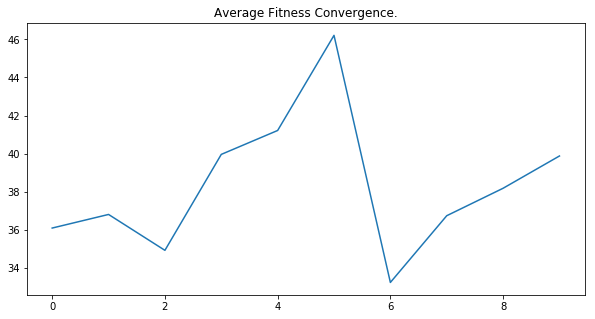

In [18]:
phis_psis = ga.optimize(10)

## Generate PDB

In [19]:
predicted_protein = phi_psi_to_pdb('1ROP-F', sequence, phis_psis)

# Q1 - c) RMSD - Peptide Bond Protein vs Experimental Protein

In [20]:
def calculate_translation(ref_atom, atom):
    return ref_atom[['x', 'y', 'z']].values.reshape(-1) -\
               atom[['x', 'y', 'z']].values.reshape(-1)


def translate_molecule_to_new_reference(ref_molecule, molecule):
    ref_atom = ref_molecule.iloc[0]
    atom = molecule.iloc[0]
    
    translation = calculate_translation(ref_atom, atom)
    return translate(molecule, translation)


def rmsd(ref_molecule, molecule, atoms):
    ref_molecule_filtered = ref_molecule[ref_molecule.atom_name.isin(atoms)].copy()
    molecule_filtered = molecule[molecule.atom_name.isin(atoms)].copy()
    translated_molecule_filtered = translate_molecule_to_new_reference(ref_molecule_filtered, molecule_filtered)
        
    molecules_df = pd.merge(ref_molecule_filtered, translated_molecule_filtered, on=['residue_seq_number', 'atom_name'])
    
    molecules_df['x_distance_squared'] = (molecules_df['x_x'] - molecules_df['x_y']) ** 2
    molecules_df['y_distance_squared'] = (molecules_df['y_x'] - molecules_df['y_y']) ** 2
    molecules_df['z_distance_squared'] = (molecules_df['z_x'] - molecules_df['z_y']) ** 2
    
    molecules_df['euclidean_distance_squared'] = (molecules_df['x_distance_squared'] + 
                                                  molecules_df['y_distance_squared'] +
                                                  molecules_df['z_distance_squared'])
    
    return np.sqrt(np.mean(molecules_df['euclidean_distance_squared']))

In [21]:
rmsd(molecule, protein, ['CA'])

101.62920740736887

# Q1 - d) RMSD - Predicted Protein vs Experimental Protein

In [22]:
rmsd(molecule, predicted_protein, ['CA'])

30.197161995612866

# Q1 - e) Structural Analysis

## Calculate Phi and Psi

In [23]:
def calculate_dihedral_angle(p1, p2, p3, p4):
    p1, p2, p3, p4 = np.array(p1), np.array(p2), np.array(p3), np.array(p4)
    
    b1 = -1.0 * (p2 - p1)
    b2 = p3 - p2
    b3 = p4 - p3
    
    # normalize b2
    b2 /= np.linalg.norm(b2)
    
    # projections of b1 and b3 onto plane perpendicular to b2
    v = b1 - np.dot(b1, b2) * b2
    w = b3 - np.dot(b3, b2) * b2
    
    # angle between v and w is the torsion angle
    x = np.dot(v, w)
    y = np.dot(np.cross(b2, v), w)
    return np.degrees(np.arctan2(y, x))

In [24]:
def _infer_phi(c_previous, n_current, c_alpha_current, c_current):
    return calculate_dihedral_angle(c_previous, n_current, c_alpha_current, c_current)


def _infer_psi(n_current, c_alpha_current, c_current, n_next):
    return calculate_dihedral_angle(n_current, c_alpha_current, c_current, n_next)


def infer_phi_psi(protein):
    phi_psi = pd.DataFrame(data=None, columns=['amino', 'phi', 'psi'])    
    previous_aminoacid = None
    
    for i in protein.residue_seq_number.unique():
        current_aminoacid = protein[protein.residue_seq_number == str(i)].copy()
        next_aminoacid = protein[protein.residue_seq_number == str(int(i)+1)].copy() 
        next_aminoacid = next_aminoacid if not next_aminoacid.empty else None
        
        c_previous = previous_aminoacid[previous_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)\
                     if previous_aminoacid is not None else None
        n_current = current_aminoacid[current_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)
        c_alpha_current = current_aminoacid[current_aminoacid.atom_name == 'CA'][['x', 'y', 'z']].values.reshape(-1)
        c_current = current_aminoacid[current_aminoacid.atom_name == 'C'][['x', 'y', 'z']].values.reshape(-1)
        n_next = next_aminoacid[next_aminoacid.atom_name == 'N'][['x', 'y', 'z']].values.reshape(-1)\
                 if next_aminoacid is not None else None

        
        phi = _infer_phi(c_previous, n_current, c_alpha_current, c_current) if previous_aminoacid is not None else None
        psi = _infer_psi(n_current, c_alpha_current, c_current, n_next) if next_aminoacid is not None else None
        
        previous_aminoacid = current_aminoacid
        
        new_phi_psi = pd.DataFrame(data={'amino': [current_aminoacid.residue_name.iloc[0]], 
                                         'phi': [phi], 
                                         'psi': [psi]})  
        phi_psi = phi_psi.append(new_phi_psi, sort=True, ignore_index=True)

    return phi_psi

In [25]:
predicted_phi_psi = infer_phi_psi(predicted_protein)
experimental_phi_psi = infer_phi_psi(molecule)

## Ramachandran Plot

In [26]:
def plot_ramachandran(ax, phi_psi, plot_title):
    ax.set_title('Ramachandran Plot of %s.' % (plot_title))
    ax.plot(phi_psi.phi, phi_psi.psi, '*')
    ax.plot(np.linspace(-180, 180, len(phi_psi.phi)), np.zeros(len(phi_psi.psi)), 'k')
    ax.plot(np.zeros(len(phi_psi.phi)), np.linspace(-180, 180, len(phi_psi.psi)), 'k')
    ax.set(xlabel='Phi', ylabel='Psi')
    ax.grid()
    ax.axis([-180, 180, -180, 180])

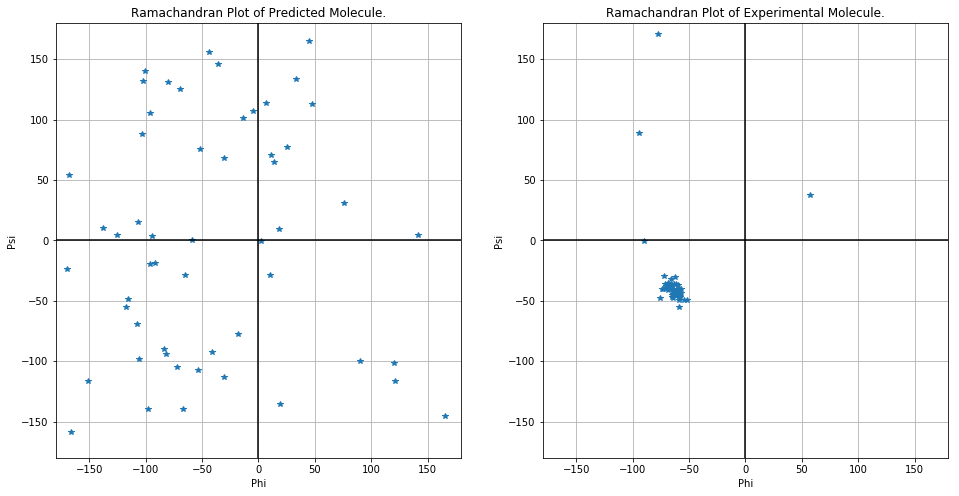

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
plot_ramachandran(ax[0], predicted_phi_psi,'Predicted Molecule')
plot_ramachandran(ax[1], experimental_phi_psi, 'Experimental Molecule')

## Secondary Structure

In [28]:
alpha_helix_phi_range = (-89, -39)
alpha_helix_psi_range = (-66, -16)

beta_sheet_phi_range = (-130, -105)
beta_sheet_psi_range = (128, 147)

In [29]:
def is_between(value, _range):
    return _range[0] < value < _range[1]

def is_alpha_helix(phi, psi):
    is_helix_phi = is_between(phi, alpha_helix_phi_range)
    is_helix_psi = is_between(psi, alpha_helix_psi_range)
    return is_helix_phi and is_helix_phi

def is_beta_sheet(phi, psi):
    is_sheet_phi = is_between(phi, beta_sheet_phi_range)
    is_sheet_psi = is_between(psi, beta_sheet_psi_range)
    return is_sheet_phi and is_sheet_phi

In [30]:
def infer_secondary_structure(phi_psi_df):
    secondary_structure = ''
    for i, row in phi_psi_df.iterrows():
        phi, psi = row.phi, row.psi
        
        if phi is not None and psi is not None:
            if is_alpha_helix(phi, psi):
                secondary_structure += ('H')
            elif is_beta_sheet(phi, psi):
                secondary_structure += ('S')
            else:
                secondary_structure += ('-')
        else:
            secondary_structure += ('-')

    return secondary_structure

In [31]:
predicted_secondary_structure = infer_secondary_structure(predicted_phi_psi)
experimental_secondary_structure = infer_secondary_structure(experimental_phi_psi)

In [32]:
print('Primary Structure:')
print('    %s\n' % sequence)
print('Secondary Structure:')
print('  Predicted:\n    %s' % predicted_secondary_structure)
print('  Experimental:\n    %s' % experimental_secondary_structure)

Primary Structure:
    MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHADELYRSCLARF

Secondary Structure:
  Predicted:
    ----H---HH----SS-H---S-------H-H--H-H------SSHHHH-S-----
  Experimental:
    -HHHHHHHHHHHHHHHHHHHHHHHHHHH---HHHHHHHHHHHHHHHHHHHHHHHH-


### α-Helix and β-Sheet percentage

In [33]:
predicted_alpha_helix_percentage = np.mean([r == 'H' for r in predicted_secondary_structure]) * 100
predicted_beta_sheet_percentage = np.mean([r == 'S' for r in predicted_secondary_structure]) * 100

experimental_alpha_helix_percentage = np.mean([r == 'H' for r in experimental_secondary_structure]) * 100
experimental_beta_sheet_percentage = np.mean([r == 'S' for r in experimental_secondary_structure]) * 100

In [39]:
print('Predicted:\n  - α-Helix: %.1f%%\n  - β-Sheet: %.1f%%' % 
      (predicted_alpha_helix_percentage, predicted_beta_sheet_percentage))
print('Experimental:\n  - α-Helix: %.1f%%\n  - β-Sheet: %.1f%%' % 
      (experimental_alpha_helix_percentage, experimental_beta_sheet_percentage))

Predicted:
  - α-Helix: 21.4%
  - β-Sheet: 10.7%
Experimental:
  - α-Helix: 91.1%
  - β-Sheet: 0.0%


## What does Energy mean?

In [35]:
experimental_phi_psi_list = [p for phi_psi in experimental_phi_psi[['phi', 'psi']].values for p in phi_psi]
experimental_phi_psi_list[0] = 0.0
experimental_phi_psi_list[-1] = 0.0

In [36]:
phi_psi_to_xyz('experimental', sequence, experimental_phi_psi_list)
print('Energy for Phis and Psis from the experimental molecule: %.1f' % energy('experimental'))

Energy for Phis and Psis from the experimental molecule: 359600000000.0


In [37]:
zeros_phi_psi_list = [0.0] * len(sequence)

In [38]:
phi_psi_to_xyz('zeros', sequence, zeros_phi_psi_list)
print('Energy for Phis and Psis equal to Zero: %.1f' % energy('zeros'))

Energy for Phis and Psis equal to Zero: 7010.5


Why does calculating the energy using Phis and Psis equal to zero give lower energy than calculating the energy using Phis and Psi from the experimental molecule?

Done!